In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

Load data to build training instances

In [ ]:
#load data from mat files
data_origin = loadmat('/content/drive/MyDrive/Projects/Data/DeepDenoise/noise_dataset3.mat')
#test_origin = loadmat('/content/drive/MyDrive/Projects/Data/DeepDenoise/test_dataset.mat')

Set the device to work on: GPU or CPU

In [ ]:
dev = torch.device("cuda:0")

In [ ]:
dev

device(type='cuda', index=0)

Create datasets corresponding to the different components of the signal. Namely, the clean component containing the dynamics of Acetylcholine and hemodynamics, the dark noise and shot noise in emission and shot noise of the excitation light.



In [ ]:
#Create datasets
l1 = np.shape(data_origin['train_clean'])

train_clean = torch.tensor(data_origin['train_clean'],dtype=torch.float,device=dev).view((l1[0],1,l1[1],l1[2]))
train_dark = torch.tensor(data_origin['train_dark'],dtype=torch.float,device=dev).view((l1[0],1,l1[1],l1[2]))
train_shot = torch.tensor(data_origin['train_shot'],dtype=torch.float,device=dev).view((l1[0],1,l1[1],l1[2]))

In [ ]:
train_ex = torch.mean(train_shot[:,:,:,:10],dim=3,keepdim=True)
train_ex = train_ex/torch.mean(train_ex,dim=2,keepdim=True)*10-9
print(train_ex.shape)

torch.Size([1000, 1, 101, 1])


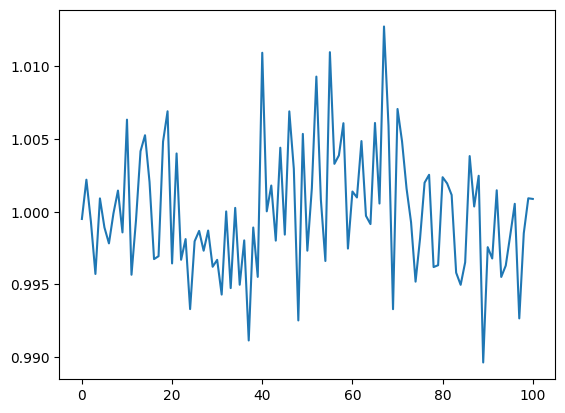

In [ ]:
plt.plot(range(101),train_ex[3,0,:,0].cpu())
plt.show()

Define CNN for denoising

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1):
        """Pytorch implementation of DnCNN. Implementation followed the original paper [1]_. Authors original code can be
        found on `their Github Page
        <https://github.com/cszn/DnCNN/>`_.

        Notes
        -----
        This implementation is based on the following `Github page
        <https://github.com/SaoYan/DnCNN-PyTorch>`_.

        Parameters
        ----------
        depth : int
            Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
            blind denoising and depth=20 for blind denoising.
        n_filters : int
            Number of filters on each convolutional layer.
        kernel_size : int tuple
            2D Tuple specifying the size of the kernel window used to compute activations.
        n_channels : int
            Number of image channels that the network processes (1 for grayscale, 3 for RGB)

        References
        ----------
        .. [1] Zhang K, Zuo W, Chen Y, Meng D, Zhang L. Beyond a gaussian denoiser: Residual learning of deep cnn
               for image denoising. IEEE Transactions on Image Processing. 2017

        Example
        -------
        >>> from OpenDenoising.model.architectures.pytorch import DnCNN
        >>> dncnn_s = DnCNN(depth=17)
        >>> dncnn_b = DnCNN(depth=20)

        """
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=1, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=1, bias=False))
        self.dncnn = nn.Sequential(*layers)


  def forward(self, x):
    out = self.dncnn(x)
    return out



Define the training function

In [ ]:
from torch.utils.data.dataloader import RandomSampler

def trainNet(net, data_clean, data_noise_dark, data_noise_shot, data_noise_ex, optimizer,criterion, batch_size=10, epochs=4, printr=False, save_loss=False):
    """Function to train the neural network
        Inputs:
            net: network to train
            batch_size: size of the mini-batch used in the SGD optimization
            epochs: number of traning epochs
            epoch start: number of epochs run so far + 1. Used to keep track of total training
                epochs when the function takes an already pretrained network as input
            printr: boolean to determine whether running loss is displayed during execution
            save_loss: boolean used to indicate wheter to store information about the running loss"""
 

    clean_sampler = RandomSampler(data_clean)
    noise_dark_sampler = RandomSampler(data_noise_dark)
    noise_shot_sampler = RandomSampler(data_noise_shot)
    noise_ex_sampler = RandomSampler(data_noise_ex)

    # create training loader
    cleanloader = DataLoader(data_clean,batch_size=int(batch_size),sampler = clean_sampler)
    noisedarkloader = DataLoader(data_noise_dark,batch_size=int(batch_size),sampler=noise_dark_sampler)
    noiseshotloader = DataLoader(data_noise_shot,batch_size=int(batch_size),sampler=noise_shot_sampler)
    noisexloader = DataLoader(data_noise_ex,batch_size=int(batch_size),sampler=noise_ex_sampler)

    #train
    import time 
    start = time.time()
    #global loss
    epoch_start = 0

    for epoch in range(epochs):  # loop over the dataset multiple times
        
        epoch_start += 1
        running_loss = 0.0
        rloss = []
        
        for i, (clean,noise_dark,noise_shot,noisex) in enumerate(zip(cleanloader,noisedarkloader,noiseshotloader,noisexloader)):
            
            #the noise in fluorescence emission caused by shot noise in the excitation light
            #manifests as a fluctuating wavelength-independent factor
            noisex = clean*noisex-clean

            #the shot noise in emission is wavelength-dependent, scaling with the square root
            #of intensity at each wavelength
            noise_shot = noise_shot / torch.sqrt(torch.mean(noise_shot, dim=2, keepdim=True) / torch.mean(clean, dim=2, keepdim=True))
            noise_shot = noise_shot-torch.mean(noise_shot,dim=2,keepdim=True)
            
            #shot noise and excitation noise are scaled by a random number 0.05-0.55
            #used to make the model more generalizable across different noise magnitudes
            rand_shot = (torch.rand(1,device=dev)*0.5+0.05)
            rand_ex = (torch.rand(1,device=dev)*0.5+0.05)
            noise = noise_dark+rand_shot*noise_shot+rand_ex*noisex

            #the sample is the sum of the clean and noise components
            sample = clean+noise
            
            # zero the parameter gradients
            optimizer.zero_grad()

            #compute network output
            outputs=net(sample)
            
            #calculate loss
            loss = criterion(outputs, noise)
            
            #update weights based on backpropagation
            loss.backward()

            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            optimizer.step()

            if save_loss:
                rloss.append(loss.item())

            if printr:
                # print statistics
                running_loss += loss.item()

                if (i+1) % (batch_size) == 0:    # print every 10 mini-batches
                    print(f"[{epoch+1}, {i+1}] loss: {np.round(running_loss/(batch_size*2)*1e-6,7)}")
                    #print('[%d, %5d] loss: %.3f' %
                    #    (epoch + 1, i + 1, running_loss / 5))
                    running_loss = 0.0
    
    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)
    
    if save_loss:
        return rloss

Create test function

In [ ]:
def testNet(net, data_clean, data_noise_dark, data_noise_shot, data_noise_ex, batch_size=1):
    """Test function"""
 
    #net = net.float()
    #net.to(dev)

    clean_sampler = RandomSampler(data_clean)
    noise_dark_sampler = RandomSampler(data_noise_dark)
    noise_shot_sampler = RandomSampler(data_noise_shot)
    noise_ex_sampler = RandomSampler(data_noise_ex)

    # create training loader
    cleanloader = DataLoader(data_clean,batch_size=int(batch_size),sampler = clean_sampler)
    noisedarkloader = DataLoader(data_noise_dark,batch_size=int(batch_size),sampler=noise_dark_sampler)
    noiseshotloader = DataLoader(data_noise_shot,batch_size=int(batch_size),sampler=noise_shot_sampler)
    noisexloader = DataLoader(data_noise_ex,batch_size=int(batch_size),sampler=noise_ex_sampler)
        
    for i, (clean,noise_dark,noise_shot,noisex) in enumerate(zip(cleanloader,noisedarkloader,noiseshotloader,noisexloader)):
        
        noisex = clean*noisex-clean
        noise_shot = noise_shot / torch.sqrt(torch.mean(noise_shot, dim=2, keepdim=True) / torch.mean(clean, dim=2, keepdim=True))
        noise_shot = noise_shot-torch.mean(noise_shot,dim=2,keepdim=True)
        #noise = noise_dark+noise_shot+noisex
        noise = noise_dark+(torch.rand(1,device=dev)*0.5+0.05)*noise_shot+(torch.rand(1,device=dev)*0.5+0.05)*noisex
        sample = clean+noise
        
        #compute network output
        outputs=net(sample)
  
    return sample, outputs, noise
            

Function to save model checkpoint

In [ ]:
def SaveCheckpoint(path):
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },path)

Load pre-trained model if necessary

In [ ]:
model_dict = torch.load('/content/drive/MyDrive/Projects/Data/DeepDenoise/DnCNN_absoluteF_rescalednoise3.pth')
state_dict = model_dict['model_state_dict']
net = DnCNN()
net.load_state_dict(state_dict)
net.to(dev)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size

In [ ]:
#net = DnCNN().float().to(dev)
    
# #create optimizer
criterion = nn.MSELoss(size_average=False)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
trainNet(net,train_clean,train_dark,train_shot,train_ex,optimizer,criterion,batch_size=20,epochs=50,printr=True)

In [ ]:
#save model checkpoint
SaveCheckpoint('/content/drive/MyDrive/Projects/Data/DeepDenoise/DnCNN_absoluteF_rescalednoise3.pth')

Check the trained model performance

In [ ]:
netin, netout, target = testNet(net,train_clean,train_dark,train_shot,train_ex)

In [ ]:
netin = netin.squeeze().cpu()
netout = netout.squeeze().cpu().detach().numpy()
target = target.squeeze().cpu()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.shape(target)

torch.Size([121, 172])

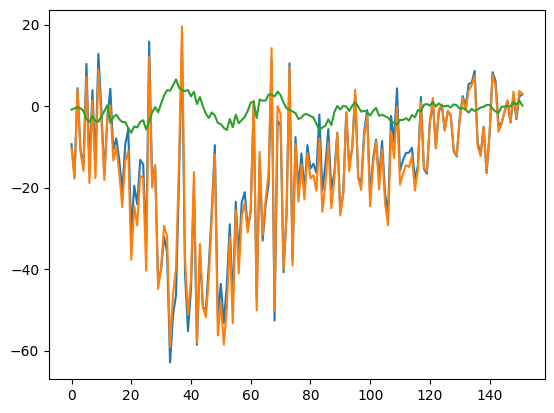

In [ ]:
plt.plot(range(152),netout[73,:])
plt.plot(range(152),target[73,:])
plt.plot(range(152),target[73,:]-netout[73,:])
plt.show()

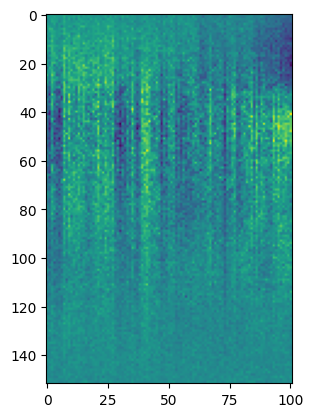

In [ ]:
plt.imshow(np.apply_along_axis(lambda x: x-np.mean(x),1, netin.T))
plt.show()

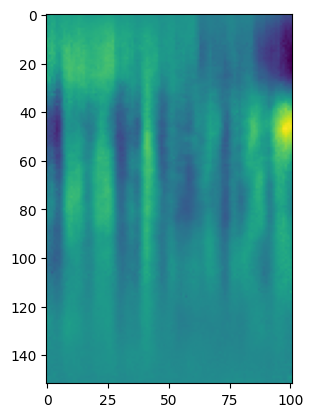

In [ ]:
plt.imshow(np.apply_along_axis(lambda x: x-np.mean(x),1, netin.T-netout.T))
plt.show()

In [ ]:
test_origin = loadmat('/content/drive/MyDrive/Projects/Data/DeepDenoise/test_dataset.mat')
l1=np.shape(test_origin['test_inst'])
test_data = torch.tensor(test_origin['test_inst'],dtype=torch.float,device=dev).view((100,1,l1[1],l1[2]))

In [ ]:
test_inst = test_data[9,:,:,:].view((1,1,l1[1],l1[2]))
net_inst = net(test_inst)

In [ ]:
np.shape(test_inst)

torch.Size([100, 1, 101, 152])

In [ ]:
netin = test_inst.squeeze().cpu()
netout = net_inst.squeeze().cpu().detach().numpy()

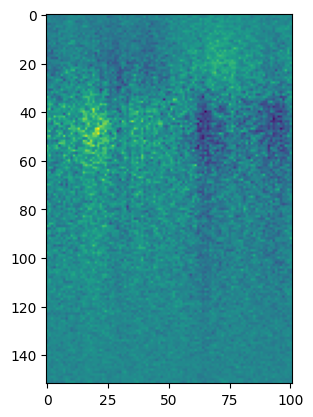

In [ ]:
plt.imshow(np.apply_along_axis(lambda x: x-np.mean(x),1, netin.T))
plt.show()

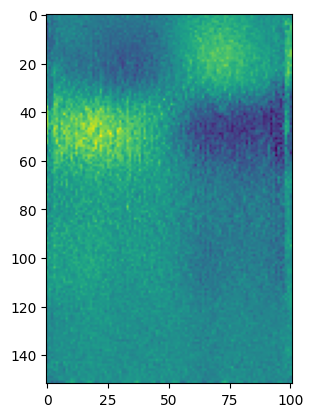

In [ ]:
plt.imshow(np.apply_along_axis(lambda x: x-np.mean(x),1, netin.T-netout.T))
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter

netinsm = gaussian_filter(netin,sigma=(2,2))

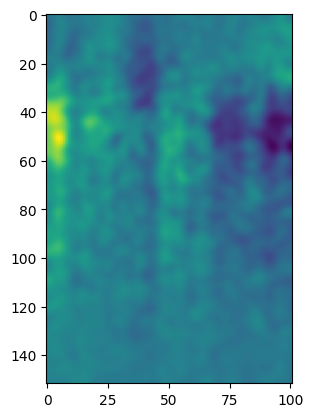

In [ ]:
plt.imshow(np.apply_along_axis(lambda x: x-np.mean(x),1, netinsm.T))
plt.show()